# Első próbálkozás

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
import cv2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
tf.compat.v1.enable_v2_behavior

<function tensorflow.python.compat.v2_compat.enable_v2_behavior()>

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(gpus, tf.test.gpu_device_name())

[] 


In [66]:
DATA_DIRECTORY = '.\\data\\data'
UNDERSAMPLED_DIRECTORY = '.\\data\\modified-data'

IMAGE_SIZE = (224, 224)
NUMBER_OF_CLASSES = 50

In [67]:
UNDERSAMPLE_VALUE = 200

IMAGE_EXTENSIONS = ['jpeg', 'jpg', 'bmp', 'png']

os.makedirs(UNDERSAMPLED_DIRECTORY, exist_ok=True)

for image_class in os.listdir(DATA_DIRECTORY):
    for i, image in enumerate(os.listdir(os.path.join(DATA_DIRECTORY, image_class))):
        if i > UNDERSAMPLE_VALUE:
            break
        image_path = os.path.join(DATA_DIRECTORY, image_class, image)
        try:
            if os.path.splitext(image_path)[-1].lower()[1:] in IMAGE_EXTENSIONS:
                img = cv2.imread(image_path)
                img = cv2.resize(img, IMAGE_SIZE)
                modified_image_path = os.path.join(UNDERSAMPLED_DIRECTORY, image_class, image)
                os.makedirs(os.path.dirname(modified_image_path), exist_ok=True)
                cv2.imwrite(modified_image_path, img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

In [6]:
def draw_distribution_graph(dataset):
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[label] = class_counts.get(label, 0) + 1

    class_names = [str(i) for i in range(NUMBER_OF_CLASSES)]
    class_counts_values = [class_counts.get(int(class_name), 0) for class_name in class_names]

    plt.bar(class_names, class_counts_values)
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Number of images by class')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIRECTORY,
    image_size=IMAGE_SIZE,
    class_names=[str(i) for i in range(NUMBER_OF_CLASSES)]
)
draw_distribution_graph(data)

Found 8836 files belonging to 50 classes.


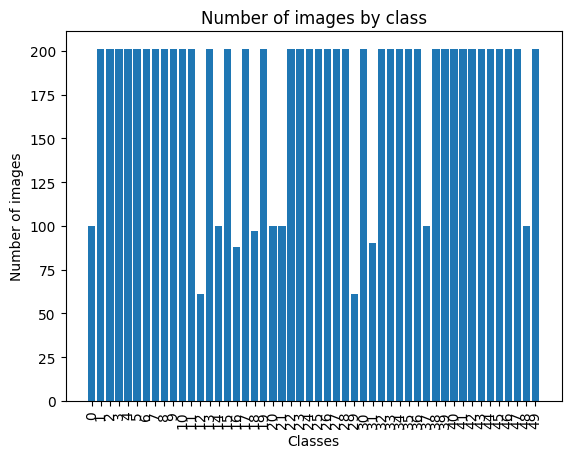

In [8]:
data = tf.keras.utils.image_dataset_from_directory(
    directory=UNDERSAMPLED_DIRECTORY,
    image_size=IMAGE_SIZE,
    class_names=[str(i) for i in range(NUMBER_OF_CLASSES)]
)
draw_distribution_graph(data)

In [9]:
data = data.map(lambda x,y: (x/255, y)) # .map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE), y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_dataset = data.take(train_size)
validation_dataset = data.skip(train_size).take(validation_size)
test_dataset = data.skip(train_size+validation_size).take(test_size)

In [10]:
model_0 = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE+(3,)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(50, activation='softmax')
])

model_0.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

In [11]:
model_0.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [12]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [13]:
hist_0 = model_0.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)

Epoch 1/40


d:\Personal\Users\Marci\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


193/193 [==============================] - 293s 2s/step - loss: 3.8492 - acc: 0.0494 - val_loss: 3.6334 - val_acc: 0.0744
Epoch 2/40
193/193 [==============================] - 294s 2s/step - loss: 3.3845 - acc: 0.1208 - val_loss: 3.4129 - val_acc: 0.1324
Epoch 3/40
193/193 [==============================] - 294s 2s/step - loss: 2.4568 - acc: 0.3433 - val_loss: 3.6372 - val_acc: 0.1591
Epoch 4/40
193/193 [==============================] - 295s 2s/step - loss: 0.9743 - acc: 0.7403 - val_loss: 4.5734 - val_acc: 0.1676
Epoch 5/40
193/193 [==============================] - 296s 2s/step - loss: 0.3328 - acc: 0.9165 - val_loss: 6.2688 - val_acc: 0.1949
Epoch 6/40
193/193 [==============================] - 295s 2s/step - loss: 0.1928 - acc: 0.9573 - val_loss: 6.7526 - val_acc: 0.1937
Epoch 7/40
193/193 [==============================] - 295s 2s/step - loss: 0.1157 - acc: 0.9778 - val_loss: 7.8713 - val_acc: 0.1864


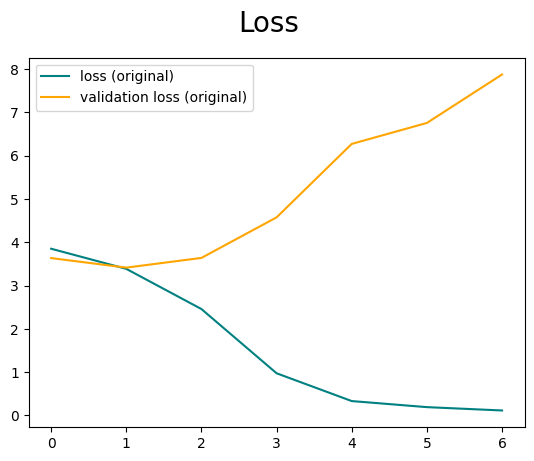

In [14]:
loss_fig = plt.figure()
plt.plot(hist_0.history['loss'], color='teal', label='loss (original)')
plt.plot(hist_0.history['val_loss'], color='orange', label='validation loss (original)')
loss_fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

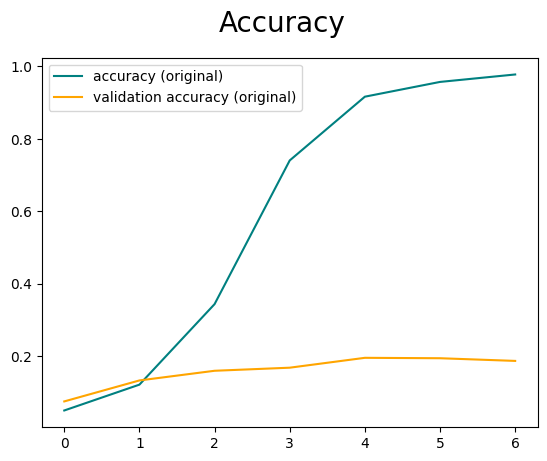

In [15]:
acc_fig = plt.figure()
plt.plot(hist_0.history['acc'], color='teal', label='accuracy (original)')
plt.plot(hist_0.history['val_acc'], color='orange', label='validation accuracy (original)')
acc_fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [16]:
model_0.evaluate(test_dataset)

27/27 [==============================] - 12s 285ms/step - loss: 3.4827 - acc: 0.0995


[3.4826581478118896, 0.09953703731298447]

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_0)
tflite_model = converter.convert()
with open('model_0.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmpeqwtnaii\assets


INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmpeqwtnaii\assets


In [24]:
tacsko = Image.open(os.path.join(UNDERSAMPLED_DIRECTORY, '0', 'Image_1.jpg')).resize((224, 224))
tacsko = np.array(tacsko)/255.0
result = model_0.predict(tacsko[np.newaxis, ...])
result

1/1 [==============================] - 0s 214ms/step


array([[6.2589742e-02, 3.2425523e-03, 1.9441225e-03, 4.7128811e-02,
        7.9416735e-03, 9.4249600e-04, 2.1832950e-04, 9.4953168e-05,
        1.3830012e-04, 2.5192490e-02, 1.0996503e-02, 1.5119896e-03,
        8.6563954e-04, 6.8207149e-04, 6.8245572e-03, 1.0020321e-02,
        9.3705807e-05, 1.4297241e-04, 5.8535785e-05, 3.9119975e-04,
        6.6248933e-04, 1.2134652e-03, 1.5696928e-01, 7.5533037e-04,
        3.3215743e-05, 3.5160746e-02, 3.4544694e-03, 2.4342344e-03,
        2.1899598e-04, 2.4946501e-02, 2.5283636e-03, 4.8054368e-04,
        2.7324547e-04, 6.0603297e-03, 9.8175764e-02, 1.9740875e-04,
        1.8661289e-02, 9.9815679e-06, 4.5794714e-03, 2.2624261e-03,
        1.9001983e-02, 2.1311421e-02, 6.7087924e-05, 3.6040306e-02,
        1.4977072e-03, 9.7110318e-03, 4.8666974e-04, 3.1188554e-01,
        5.9371356e-02, 5.2842614e-04]], dtype=float32)

# **Súly optimalizáció**

In [ ]:
UNDERSAMPLE_VALUE = 1000

IMAGE_EXTENSIONS = ['jpeg', 'jpg', 'bmp', 'png']

os.makedirs(UNDERSAMPLED_DIRECTORY, exist_ok=True)

for image_class in os.listdir(DATA_DIRECTORY):
    for i, image in enumerate(os.listdir(os.path.join(DATA_DIRECTORY, image_class))):
        if i > UNDERSAMPLE_VALUE:
            break
        image_path = os.path.join(DATA_DIRECTORY, image_class, image)
        try:
            if os.path.splitext(image_path)[-1].lower()[1:] in IMAGE_EXTENSIONS:
                img = cv2.imread(image_path)
                img = cv2.resize(img, IMAGE_SIZE)
                modified_image_path = os.path.join(UNDERSAMPLED_DIRECTORY, image_class, image)
                os.makedirs(os.path.dirname(modified_image_path), exist_ok=True)
                cv2.imwrite(modified_image_path, img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

Found 17445 files belonging to 50 classes.


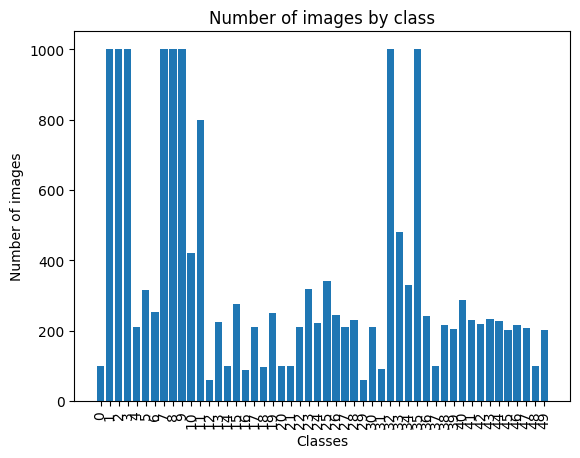

In [74]:
data = tf.keras.utils.image_dataset_from_directory(
    directory=UNDERSAMPLED_DIRECTORY,
    image_size=IMAGE_SIZE,
    class_names=[str(i) for i in range(NUMBER_OF_CLASSES)]
)
draw_distribution_graph(data)

In [80]:
data = data.map(lambda x,y: (x/255, y)) # .map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE), y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_dataset = data.take(train_size)
validation_dataset = data.skip(train_size).take(validation_size)
test_dataset = data.skip(train_size+validation_size).take(test_size)

In [81]:
model_1 = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE+(3,)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(50, activation='softmax')
])

model_1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 26, 26, 128)     

In [82]:
model_1.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [83]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5
)

labels = np.concatenate([labels for images, labels in train_dataset], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights

array([3.44338028, 0.34628895, 0.33444596, 0.34579915, 1.68606897,
       1.12146789, 1.3432967 , 0.36435171, 0.35227666, 0.34050139,
       0.89226277, 0.41791453, 5.82095238, 1.65189189, 3.25973333,
       1.21029703, 4.00786885, 1.73390071, 3.59529412, 1.32869565,
       3.59529412, 3.25973333, 1.68606897, 1.12146789, 1.57729032,
       1.0537931 , 1.51850932, 1.67452055, 1.54734177, 4.8896    ,
       1.61907285, 4.21517241, 0.35690511, 0.7148538 , 1.09142857,
       0.3448237 , 1.36581006, 3.49257143, 1.60842105, 1.64080537,
       1.26673575, 1.42139535, 1.528     , 1.53761006, 1.51850932,
       1.74628571, 1.67452055, 1.82447761, 3.17506494, 1.85212121])

In [84]:
hist_1 = model_1.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    class_weight={i: class_weights[i] for i in range(len(class_weights))},
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

Epoch 1/40


d:\Personal\Users\Marci\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


382/382 [==============================] - 596s 2s/step - loss: 3.8676 - acc: 0.0500 - val_loss: 3.6408 - val_acc: 0.1081 - lr: 0.0010
Epoch 2/40
382/382 [==============================] - 608s 2s/step - loss: 3.4216 - acc: 0.1104 - val_loss: 3.5141 - val_acc: 0.1058 - lr: 0.0010
Epoch 3/40
382/382 [==============================] - 615s 2s/step - loss: 2.2912 - acc: 0.2853 - val_loss: 3.7137 - val_acc: 0.1336 - lr: 0.0010
Epoch 4/40
382/382 [==============================] - 605s 2s/step - loss: 0.9302 - acc: 0.6162 - val_loss: 4.3277 - val_acc: 0.1419 - lr: 0.0010
Epoch 5/40
382/382 [==============================] - 607s 2s/step - loss: 0.3787 - acc: 0.8267 - val_loss: 5.4207 - val_acc: 0.1376 - lr: 0.0010
Epoch 6/40
382/382 [==============================] - 610s 2s/step - loss: 0.1778 - acc: 0.9265 - val_loss: 7.0966 - val_acc: 0.1519 - lr: 0.0010
Epoch 7/40
382/382 [==============================] - 605s 2s/step - loss: 0.1397 - acc: 0.9541 - val_loss: 7.1877 - val_acc: 0.1606 - 

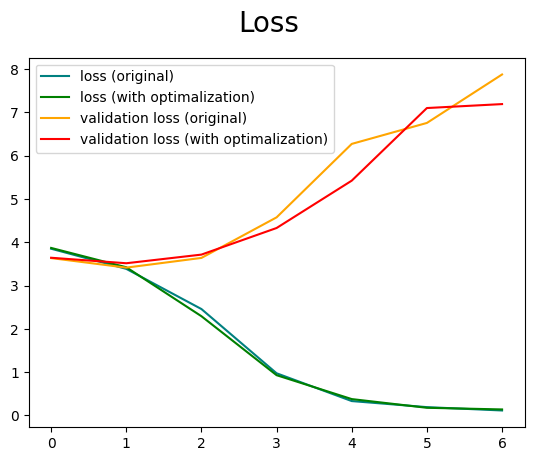

In [85]:
loss_fig = plt.figure()
plt.plot(hist_0.history['loss'], color='teal', label='loss (original)')
plt.plot(hist_1.history['loss'], color='green', label='loss (with optimalization)')
plt.plot(hist_0.history['val_loss'], color='orange', label='validation loss (original)')
plt.plot(hist_1.history['val_loss'], color='red', label='validation loss (with optimalization)')
loss_fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

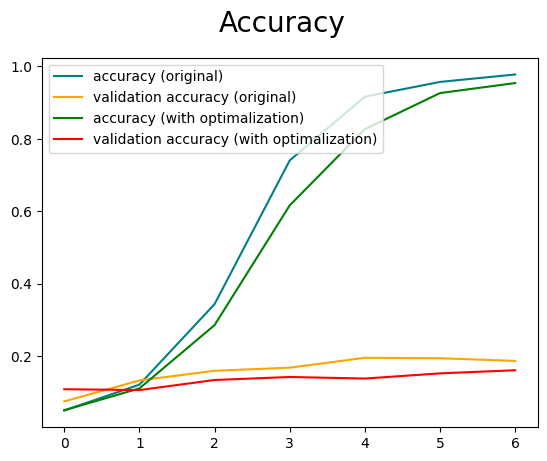

In [86]:
acc_fig = plt.figure()
plt.plot(hist_0.history['acc'], color='teal', label='accuracy (original)')
plt.plot(hist_0.history['val_acc'], color='orange', label='validation accuracy (original)')
plt.plot(hist_1.history['acc'], color='green', label='accuracy (with optimalization)')
plt.plot(hist_1.history['val_acc'], color='red', label='validation accuracy (with optimalization)')
acc_fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [87]:
model_1.evaluate(test_dataset)

54/54 [==============================] - 23s 269ms/step - loss: 3.5779 - acc: 0.0856


[3.577852964401245, 0.08564814925193787]

In [110]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()
with open('model_1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmp1mm1zw7q\assets


INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmp1mm1zw7q\assets


# **Transfer learning optimalizáció**

In [92]:
UNDERSAMPLE_VALUE = 100

IMAGE_EXTENSIONS = ['jpeg', 'jpg', 'bmp', 'png']

os.makedirs(UNDERSAMPLED_DIRECTORY, exist_ok=True)

for image_class in os.listdir(DATA_DIRECTORY):
    for i, image in enumerate(os.listdir(os.path.join(DATA_DIRECTORY, image_class))):
        if i > UNDERSAMPLE_VALUE:
            break
        image_path = os.path.join(DATA_DIRECTORY, image_class, image)
        try:
            if os.path.splitext(image_path)[-1].lower()[1:] in IMAGE_EXTENSIONS:
                img = cv2.imread(image_path)
                img = cv2.resize(img, IMAGE_SIZE)
                modified_image_path = os.path.join(UNDERSAMPLED_DIRECTORY, image_class, image)
                os.makedirs(os.path.dirname(modified_image_path), exist_ok=True)
                cv2.imwrite(modified_image_path, img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

Found 4936 files belonging to 50 classes.


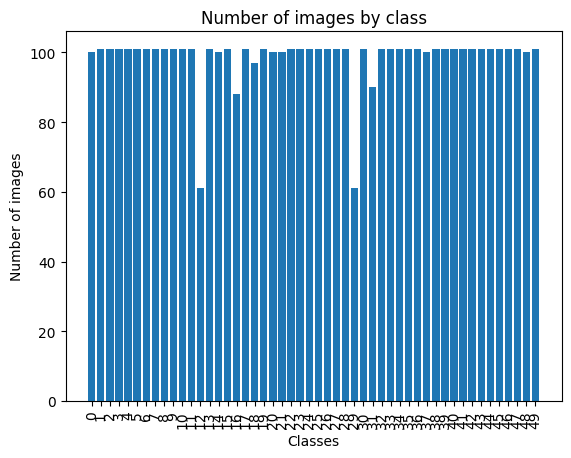

In [93]:
data = tf.keras.utils.image_dataset_from_directory(
    directory=UNDERSAMPLED_DIRECTORY,
    image_size=IMAGE_SIZE,
    class_names=[str(i) for i in range(NUMBER_OF_CLASSES)]
)
draw_distribution_graph(data)

In [99]:
data = data.map(lambda x,y: (x/255, y)) # .map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE), y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_dataset = data.take(train_size)
validation_dataset = data.skip(train_size).take(validation_size)
test_dataset = data.skip(train_size+validation_size).take(test_size)

In [94]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SIZE + (3,), trainable=False)

In [101]:
model_2 = keras.Sequential([
    pretrained_model_without_top_layer,
    keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
])

model_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_39 (Dense)            (None, 50)                64050     
                                                                 
Total params: 2322034 (8.86 MB)
Trainable params: 64050 (250.20 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [102]:
model_2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [103]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5
)

In [104]:
hist_2 = model_2.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

Epoch 1/40


d:\Personal\Users\Marci\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 66s 568ms/step - loss: 1.4115 - acc: 0.6710 - val_loss: 0.5791 - val_acc: 0.8579 - lr: 0.0010
Epoch 2/40
108/108 [==============================] - 58s 535ms/step - loss: 0.3564 - acc: 0.9158 - val_loss: 0.4133 - val_acc: 0.8871 - lr: 0.0010
Epoch 3/40
108/108 [==============================] - 57s 529ms/step - loss: 0.2241 - acc: 0.9485 - val_loss: 0.3811 - val_acc: 0.8982 - lr: 0.0010
Epoch 4/40
108/108 [==============================] - 57s 530ms/step - loss: 0.1588 - acc: 0.9670 - val_loss: 0.3279 - val_acc: 0.9093 - lr: 0.0010
Epoch 5/40
108/108 [==============================] - 58s 536ms/step - loss: 0.1167 - acc: 0.9829 - val_loss: 0.3127 - val_acc: 0.9143 - lr: 0.0010
Epoch 6/40
108/108 [==============================] - 58s 534ms/step - loss: 0.0901 - acc: 0.9902 - val_loss: 0.3023 - val_acc: 0.9143 - lr: 0.0010
Epoch 7/40
108/108 [==============================] - 58s 532ms/step - loss: 0.0727 - acc: 0.9928 - val_loss: 0.3050 - val_

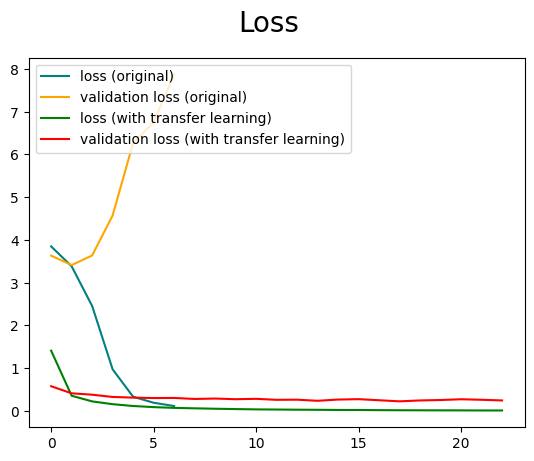

In [105]:
loss_fig = plt.figure()
plt.plot(hist_0.history['loss'], color='teal', label='loss (original)')
plt.plot(hist_0.history['val_loss'], color='orange', label='validation loss (original)')
plt.plot(hist_2.history['loss'], color='green', label='loss (with transfer learning)')
plt.plot(hist_2.history['val_loss'], color='red', label='validation loss (with transfer learning)')
loss_fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

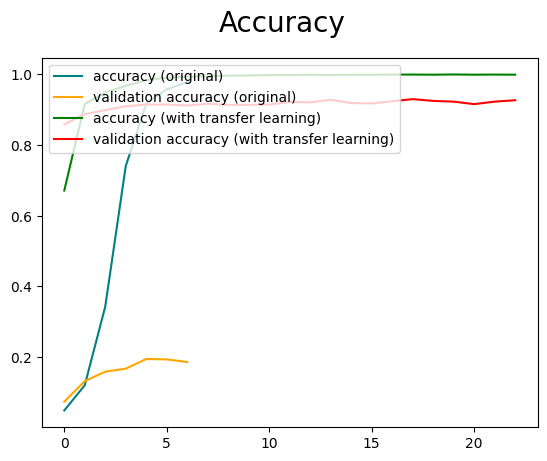

In [106]:
acc_fig = plt.figure()
plt.plot(hist_0.history['acc'], color='teal', label='accuracy (original)')
plt.plot(hist_0.history['val_acc'], color='orange', label='validation accuracy (original)')
plt.plot(hist_2.history['acc'], color='green', label='accuracy (with transfer learning)')
plt.plot(hist_2.history['val_acc'], color='red', label='validation accuracy (with transfer learning)')
acc_fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [107]:
model_2.evaluate(test_dataset)

15/15 [==============================] - 8s 373ms/step - loss: 0.3178 - acc: 0.9125


[0.31777819991111755, 0.9125000238418579]

In [109]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()
with open('model_2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmppoolbfv3\assets


INFO:tensorflow:Assets written to: C:\Users\Marci\AppData\Local\Temp\tmppoolbfv3\assets
